# Amplifier circuit


## Operational amplifiers

Operational amplifiers ("op-amp") are electronic devices to amplify an input
voltage signal. They are widely used to construct filters that remove a
desired range of frequencies from the input signal.

The schematic diagram of an op-amp is shown below. It has two terminals:
- input side (left)
- output terminal (right)

![](https://github.com/JuliaReach/ReachabilityAnalysis.jl/blob/master/examples/OpAmp/opamp.png?raw=true)

The output voltage is ``e_o = K(e_B - e_A)``, where ``K`` is the voltage gain
of the op-amp. ``K`` is usually vey large (the order of ``10^5 V / V``).

In the *ideal op-amp* scenario, the following assumptions hold:
- The input terminals of the op-amp draw negligible current.
- The voltage difference at the input terminals ``e_B - e_A`` is zero.
- The gain ``K`` is infinite.

## Inverting amplifier

Consider the following circuit, which consists of an ideal op-amp in the so-called inverting
configuration.

![](https://raw.githubusercontent.com/JuliaReach/ReachabilityAnalysis.jl/master/examples/OpAmp/opamp_c.png)

It is not hard to show [^KLU15] that the output satisfies the following ODE:

$$
   \dfrac{de_o(t)}{dt} = -\dfrac{1}{R_2 C}e_o(t) - \dfrac{1}{R_1C}e_{in}(t).
$$
The circuit exhibits a transient behavior because of the capacitor connected in parallel
to the op-amp. In the stationary limit ``t \to \infty``, ``\dfrac{de_o(t)}{dt} = 0`` and
``e_o = - \frac{R_2}{R_1} e_{in}``. The gain is thus ``- \frac{R_2}{R_1}`` and the minus sign
is the reason that this circuit is called inverting amplifier.

The output voltage ``e_o(t)`` depends on the input voltage ``e_{in}(t)``.
In order to highlight some typical assumptions on the inputs, in the rest
of this notebook we model the input voltage in different ways:

 1. **Non-deterministic input** with bounded range. This is the most general case,
    in which ``e_{in}(t) \in E_{in}``, with ``E_{in} \subseteq \mathbb{R}`` is an interval
    for the set of admissible inputs.
    This approach guarantees that the flowpipe covers all possible trajectories for any
    bounded, measurable, function ``e_{in}(t)`` satisfying the constraint ``e_{in}(t) \in E_{in}`` for all
    ``t`` of the given time span.

 2. **Constant input,** a special case such that
    ``e_{in}(t) \in E_{in}`` and ``e_{in}(t)`` is *constant* along trajectories.

 3. **Time-varying input** i.e. such that it is given by a (possibly time-varying)
    predefined function ``e_{in}(t)`` that is given by the solution of some ODE.
    In particular, we consider linear and exponential input functions.

We will consider one by one the different approaches described above in the simple
inverting amplifier circuit.

## Non-deterministic input

It is convenient to define constants ``α`` and ``β`` such that

``\dfrac{de_o(t)}{dt} = α e_o(t) + β e_{in}(t)``.

In this section we assume that ``e_{in}(t)`` can be any (measurable) function
whose range is contained in the set ``E_{in}``.

In [1]:
using ReachabilityAnalysis, Plots, LaTeXStrings

function opamp_nondet(; X0 = Interval(0.0, 0.0),
                        R₁ = 2., R₂ = 6., C = 1.e-3,
                        Ein = Interval(1.9, 2.1))

    α = hcat(-1/(R₂ * C))
    β = hcat(-1/(R₁ * C))

    # continuous evolution
    invariant = Universe(1) # no state constraint
    sys = @system(eout' = α*eout + β*ein, ein ∈ Ein, eout ∈ invariant)

    # initial-value problem
    return @ivp(sys, x(0) ∈ X0)
end

opamp_nondet (generic function with 1 method)

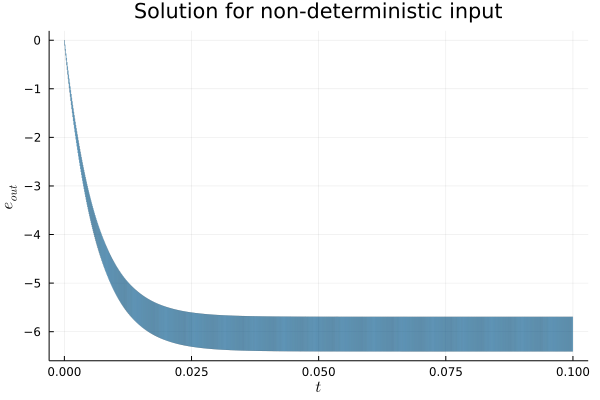

In [2]:
sol_nondet = solve(opamp_nondet(), T=0.1, alg=INT(δ=1e-4));


fig = plot()
plot!(fig, sol_nondet, vars=(0, 1), xlab=L"t", ylab=L"e_{out}", title="Solution for non-deterministic input", lw=0.2)

The solution `sol_nondet` assumed that the initial state is at the origin.
Now we solve for three different initial conditions of increasing width.

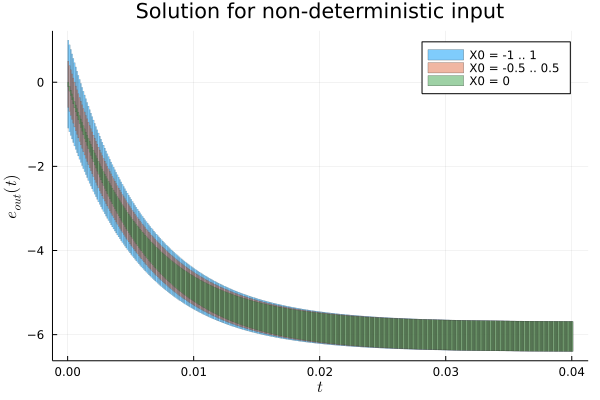

In [3]:
fig = plot(xlab=L"t", ylab=L"e_{out}(t)", title="Solution for non-deterministic input")

Δt = 0 .. 0.04

sol = solve(opamp_nondet(X0=Interval(-1.0, 1.0)), T=0.1, alg=INT(δ=1e-4));
plot!(fig, sol(Δt), vars=(0, 1), lab="X0 = -1 .. 1", lw=0.2)

sol = solve(opamp_nondet(X0=Interval(-0.5, 0.5)), T=0.1, alg=INT(δ=1e-4));
plot!(fig, sol(Δt), vars=(0, 1), lab="X0 = -0.5 .. 0.5", lw=0.2)

sol = solve(opamp_nondet(), T=0.1, alg=INT(δ=1e-4));
plot!(fig, sol(Δt), vars=(0, 1), lab="X0 = 0", lw=0.2)

fig

## Constant input

We model the input voltage ``e_{in}(t)`` with a family of ODEs of the form

``\dfrac{d e_{in}(t)}{dt} = \gamma e_{in}(t) + \delta``.

There are two distinct behaviors depending on the parameters ``\gamma`` and ``\delta``:

 - ``\gamma = \delta = 0``: ``e_{in}(t) = e_{in, 0}`` i.e. the input is *constant* over the given domain.
 - ``\gamma = 0``: linear with rate ``\delta``, it is given by ``e_{in}(t) = \delta t + e_{in, 0}``.
 - ``\gamma \neq 0``: exponential with rate ``\gamma``, it is given by ``e_{in}(t) = (e_{in, 0} + \delta / \gamma)e^{\gamma t} - \delta / \gamma``.

Moreover, it is natural to assume that the input saturates at a given threshold value.
The following function, `opamp_with_saturation`, models the system as a
hybrid automaton with two modes: in the first mode, the input signal ``e_{in}(t)``
varies according to the specified dynamics, and in the second mode, the input
signal saturates and ceases to increase (or decrease, depding on the signs chosen).

In this section we consider the constant input scenario,
- ``e_{in}(0) ∈ E_{in, 0}``, ``e_{in}(t)`` constant.
- ``\delta = 0``
- ``\gamma = 0``

In the following section we consider the other cases.

In [4]:
using Symbolics

function opamp_with_saturation(; X0 = BallInf(zeros(2), 0.0),
                                 R₁ = 2., R₂ = 6., C = 1.e-3,
                                 γ = 100., δ = 100., Es = 2.)
    var = @variables eₒ ein
    α = hcat(-1/(R₂ * C))
    β = hcat(-1/(R₁ * C))

    # transition graph
    automaton = LightAutomaton(2)
    add_transition!(automaton, 1, 2, 1)

    # modes
    A = [α β; 0. γ]
    b = [0.; δ]
    invariant = HalfSpace(ein <= Es, var)
    mode1 = @system(x' = Ax + b, x ∈ invariant)
    A = [α β; 0. 0.];
    mode2 = @system(x' = Ax, x ∈ Universe(2))
    modes = [mode1, mode2]

    # transition mode1 -> mode2 (saturation)
    guard = Hyperplane(ein == Es, var)
    t1 = @map(x -> x, dim:2, x ∈ guard)
    resetmaps = [t1]

    H = HybridSystem(automaton, modes, resetmaps, [AutonomousSwitching()])

    # initial condition is at the origin in mode 1
    initial_condition = [(1, X0)]
    return IVP(H, initial_condition)
end

opamp_with_saturation (generic function with 1 method)

Observe that in the model defined above, the first coordinate of the state-space
corresponds to the output ``e_o(t)``, while the second coordinate, ``e_{in}(t)``,
corresponds to the input signal ``e_{in}(t)``.

We specify that the initial condition is such that ``e_o(0)`` is at the origin,
and ``e_{in}(0) ∈ 1.4 .. 1.6``.

In [5]:
X0 = Hyperrectangle([0., 1.5], [0.0, 0.1]);

The value of the saturation constant ``Es`` is chosen to be sufficiently high
such that the system doesn't transition to mode 2.

In [6]:
prob_const = opamp_with_saturation(X0=X0, γ = 0., δ = 0., Es = 3.)
sol_const = solve(prob_const, T=0.1, alg=BOX(δ=1e-4));

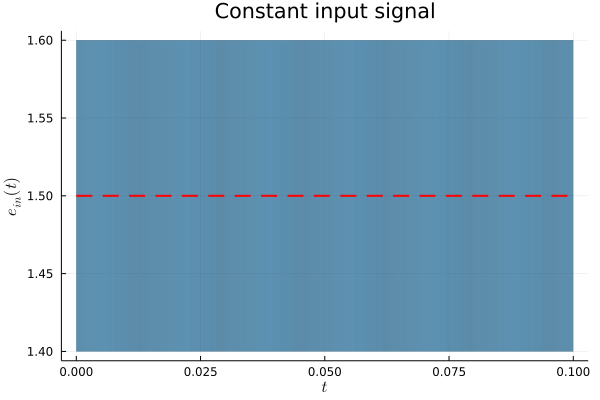

In [7]:
plot(sol_const, vars=(0, 2), xlab=L"t", ylab=L"e_{in}(t)", title="Constant input signal", lw=0.2)
plot!(x->x, x->1.5, 0., 0.1, line=2, color="red", linestyle=:dash, legend=nothing)

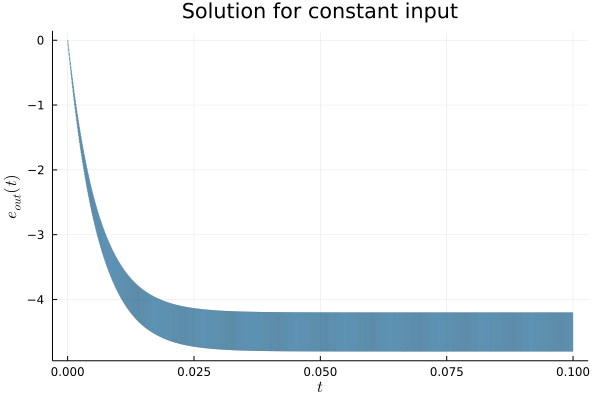

In [8]:
plot(sol_const, vars=(0, 1), xlab=L"t", ylab=L"e_{out}(t)", title="Solution for constant input", lw=0.2)

## Time-varying input

For the time-varying with a prescribed function case, we consider two scenarios:

- Linearly increasing input voltage: ``\delta \neq 0``, ``\gamma = 0``.
- Exponentially increasing input voltage (up to saturation at `Es = 1.0`): ``\delta \neq 0``, ``\gamma < 0``.

For both cases we consider that set of initial states is the origin:

In [9]:
X0 = Singleton(zeros(2));

We solve both instances by choosing som values of ``δ`` and ``γ``:

In [10]:
# linearly increasing input signal
prob_lin = opamp_with_saturation(X0=X0, γ=0., δ=100., Es=1.);
sol_lin = solve(prob_lin, T=0.1, alg=BOX(δ=1e-4));

# exponentially increasing input signal
prob_exp = opamp_with_saturation(X0=X0, γ=-100., δ=100., Es=3.);
sol_exp = solve(prob_exp, T=0.1, alg=BOX(δ=1e-4));

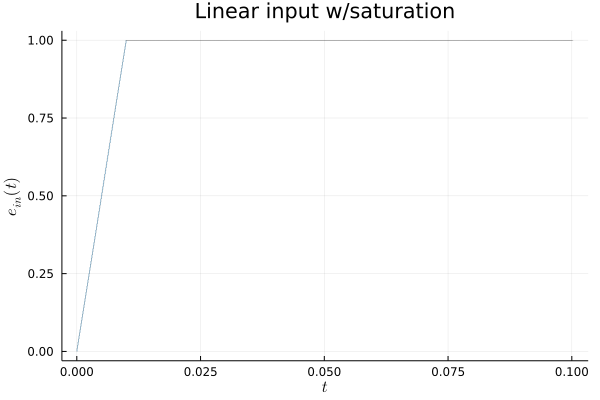

In [11]:
plot(sol_lin, vars=(0, 2), xlab=L"t", ylab=L"e_{in}(t)", title="Linear input w/saturation", lw=0.2)

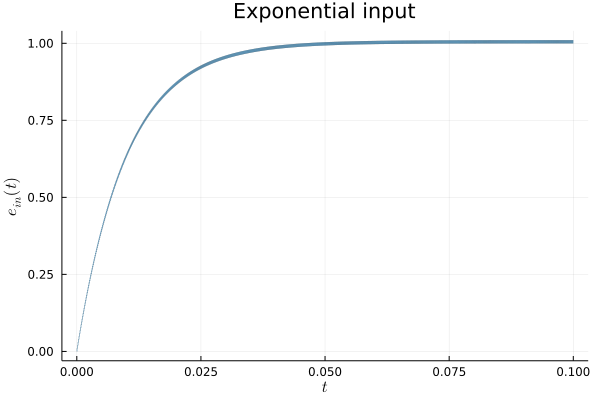

In [12]:
plot(sol_exp, vars=(0, 2), xlab=L"t", ylab=L"e_{in}(t)", title="Exponential input", lw=0.2)

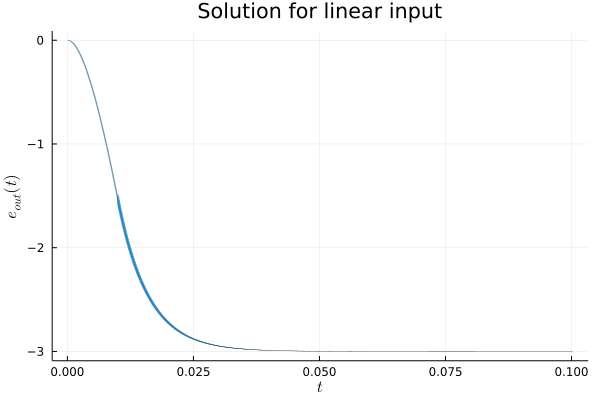

In [13]:
plot(sol_lin, vars=(0, 1), xlab=L"t", ylab=L"e_{out}(t)", title="Solution for linear input", lw=0.2)

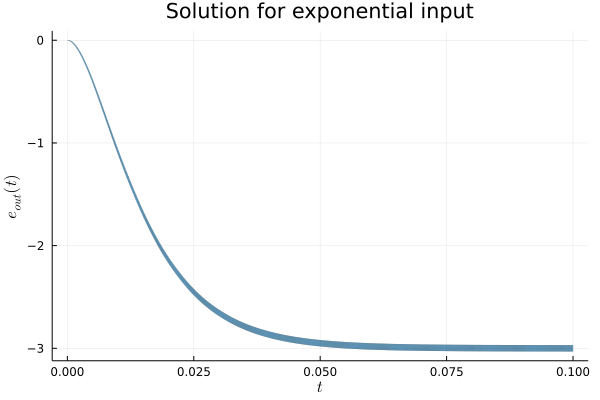

In [14]:
plot(sol_exp, vars=(0, 1), xlab=L"t", ylab=L"e_{out}(t)", title="Solution for exponential input", lw=0.2)

## References

[^KLU15]: Kluever, C. A. (2015). Dynamic systems: modeling, simulation, and control. John Wiley & Sons.